<a href="https://colab.research.google.com/github/Matteo-Candi/ADM_HW2/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 2 - ADM - group 17**

Description

In [ ]:
#Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
import datetime as dt
from scipy import stats
from scipy.stats import f_oneway, levene
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
locations = pd.read_csv('/content/drive/MyDrive/ADM/instagram_locations.csv', sep='\t')

In [ ]:
profiles = pd.read_csv('/content/drive/MyDrive/ADM/instagram_profiles.csv', sep='\t')

In [ ]:
posts = pd.read_csv('/content/drive/MyDrive/ADM/instagram_posts.csv', sep='\t')



--------------------------------------------------------------------------------

# Research Questions

## RQ1

## RQ2

Plot the number of posts for each profile in descending order

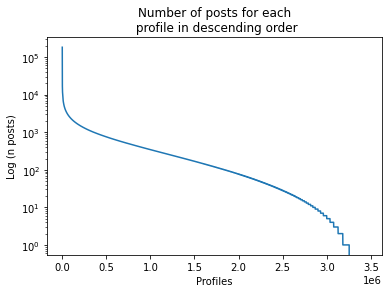

In [ ]:
n_posts = profiles.n_posts.dropna()

plt.plot(np.sort(n_posts)[::-1]);
plt.title('Number of posts for each\n profile in descending order')
plt.ylabel('Log (n posts)')
plt.xlabel('Profiles')
plt.yscale('log')

What posts have the highest number of "likes"?

In [ ]:
most_likes = pd.DataFrame(columns=['post_id', 'numbr_likes'])

for chunk in pd.read_csv('/content/drive/MyDrive/ADM/instagram_posts.csv', sep='\t', chunksize=500000, usecols=['post_id', 'numbr_likes']):
    chunk_most_like = chunk.sort_values(by='numbr_likes', ascending=False).head(5)
    most_likes = pd.concat([most_likes, chunk_most_like])

# Reading all dataset chunk by chunk we find, after sorting the values, the highest values in the chunk
# Then we take the highest among the highest.

most_likes.sort_values(by='numbr_likes', ascending=False).head(5)

,post_id,numbr_likes
19624085,Bt3yaXmAM0d,8822952.0
19623988,BuwffB7g8cK,5447066.0
19624082,Buc1gyZAaMQ,5116398.0
19623986,BvcukE8AMuG,4271466.0
39701024,BqSLFVBFLfq,4264745


What posts have the most and the least number of comments?

In [ ]:
most_comment = pd.DataFrame(columns=['post_id', 'number_comments'])
least_comment = pd.DataFrame(columns=['post_id', 'number_comments'])

for chunk in pd.read_csv('/content/drive/MyDrive/ADM/instagram_posts.csv', sep='\t', chunksize=500000, usecols=['post_id', 'number_comments']):
    chunk_most = chunk.sort_values(by='number_comments', ascending=False).head(5)
    chunk_least = chunk.sort_values(by='number_comments', ascending=False).tail(5)
    most_comment = pd.concat([most_comment, chunk_most])
    least_comment = pd.concat([least_comment, chunk_least])
  
print('Posts with most comments\n\n', most_comment.sort_values(by='number_comments', ascending=False).head(5))
print('\n\nPosts with least comments\n\n', least_comment.sort_values(by='number_comments', ascending=False).head(5))


# We take all the dataset by chunk and for every chunk, after ordering it, we take the first and the last five.
# In the end we take the highest among the highest and the lowest among the lowest.

Posts with most comments

               post_id number_comments
41873060  Bx2sPAjHviO          488953
12164781  BuGjhWAhAW5          313997
33261751  BJ-rkpTgn1N          257488
11149127  BMtisIxjhtT          214365
9383817   BzOOWj3DfZK          189888


Posts with least comments

               post_id number_comments
77497     BxhcazrhJVo               0
29752487  BwiS3P2h_sm               0
29752484  BwwhHRUganM               0
29499999  Bw4F7e-A3PB               0
29374405  BxWHjO0ntUC               0


Since the least number of comments in a post is 0, there are a lot posts with this value. Also checking the posts with 1 or 2 comments would be useless because for sure there are a lot. Differently the posts most comented are more interesting and show us the boarderline cases like the first that have almost 500k comments.


How many posts include tagged locations, and how many do not? Show it using an appropriate chart and comment your results.

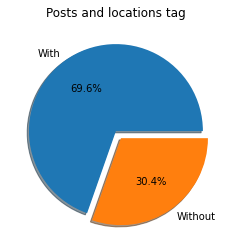

In [ ]:
loc = 0
no_loc = 0

for chunk in pd.read_csv('/content/drive/MyDrive/ADM/instagram_posts.csv', sep='\t', chunksize=500000, usecols=['location_id']):
    no_loc += chunk.location_id.isna().sum()
    loc += len(chunk)                           # Using chunks we just count the missing values in location_id column


plt.pie([loc - no_loc, no_loc], labels=['With', 'Without'], shadow=True, explode=(0, .1),autopct='%1.1f%%')
plt.title('Posts and locations tag')
plt.show()

How many posts include only photos? How many also have videos?

In [ ]:
n_photos = 0
n_multy = 0

for chunk in pd.read_csv('/content/drive/MyDrive/ADM/instagram_posts.csv', sep='\t', chunksize=500000, usecols=['post_type']):
    for el in chunk.post_type:
        if el == 1:
            n_photos +=1            # We just count the number of different values of post_type column
        elif el == 3:
            n_multy += 1

print(f'There are {n_photos} posts that include only photos.')
print(f'There are {n_multy} posts that include also videos.')

There are 41534486 posts that include only photos.
There are 40943 posts that include also videos.


What's the percentage of business accounts vs non-business? What can you interpret regarding that percentage?

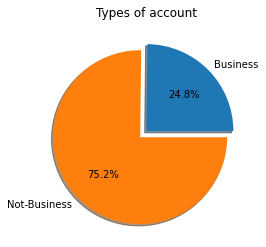

In [ ]:
business = profiles.is_business_account.dropna()
t = sum(business)
f = len(business) - t                                  # We just count the quantity of trues and falses in is_business_account column

plt.pie([t,f], labels=['Business', 'Not-Business'], shadow=True, explode=(0, .1),autopct='%1.1f%%')
plt.title('Types of account')
plt.show()

The percentage of business account tells us that despite the fact that Instagram it's been created as a platform in which to share photos and videos among users, it is also used a lot from business (almost 25% of total account in our dataset) to share their product and advertise.

## RQ3

*What is the most common time in which users publish their posts?*

In [ ]:
def post_time(data, count):
    postime = pd.to_datetime(data.cts).dt.floor('Min').dt.time
    grouping = postime.groupby(postime).size().sort_values(ascending=False).head(count)
    timing = grouping.index.to_list()
    for i in timing:
        print('{:02d}:{:02d}:{:02d}'.format(i.hour, i.minute, i.second))
print('The most common time in which users publish their posts:', end=' ')
post_time(posts, 1)

The most common time in which users publish their posts: 18:00:00


Create a function that receives a time intervals list as a parameter and returns a plot with the number of posts for each given interval.

In [ ]:
def plot_posts_time(posts_time):
    f = plt.figure()
    x_tick = [('06:00:00', '10:59:59'),('11:00:00', '13:59:59'),('14:00:00', '16:59:59'),('17:00:00', '19:59:59'),('20:00:00', '23:59:59'),('00:00:00', '02:59:59'),('03:00:00', '05:59:59')]
    plt.xticks(x_tick, ["{}:00".format(x).zfill(5) for x in range(0,25)])
    plt.ylabel("Number of posts", fontsize=14, labelpad=20)
    plt.xlabel("Time", fontsize=14, labelpad=20)
    plt.title("Daily temporal distribution of posts published", fontsize=18)
    plt.hist(posts_time, bins=range(25), color='blue', ec="k")
    f.set_figwidth(14)
    f.set_figheight(8)

    return

In [ ]:
def time_interval(data, intervals):
    datex = pd.DataFrame(pd.to_datetime(data.cts))
    datex.set_index(pd.DatetimeIndex(datex.cts), inplace=True)
    calc = 0
    value_counts = pd.DataFrame()
    for interval in intervals:
        start, end = interval
        total = datex.between_time(start, end).count()
        total = int(total[0])
        print([interval],total)
        RES = pd.DataFrame({'time interval (start, end)' : [interval], 'total posts' : total})
        value_counts = value_counts.append(RES)
        calc += total
    sns.set()
    
    ax = value_counts.plot(figsize=(14,8), kind='bar', color = 'blue', zorder=3)
    a = [0, 1, 2, 3, 4, 5, 6]
    plt.xticks(a, intervals, rotation = 30)   
    plt.xlabel("Time", fontsize=14, labelpad=20)
    plt.ylabel("Number of posts", fontsize=14, labelpad=20)
    plt.title("Daily temporal distribution of posts published", fontsize=18)
    plt.show()

Use the function that you created in the previous literal to plot the number of posts between the following time intervals:

In [ ]:
time_intervals = [('06:00:00', '10:59:59'),('11:00:00', '13:59:59'),('14:00:00', '16:59:59'),('17:00:00', '19:59:59'),('20:00:00', '23:59:59'),('00:00:00', '02:59:59'),('03:00:00', '05:59:59')]

[('06:00:00', '10:59:59')] 6378572
[('11:00:00', '13:59:59')] 5614715
[('14:00:00', '16:59:59')] 6763037
[('17:00:00', '19:59:59')] 7409907
[('20:00:00', '23:59:59')] 8915794
[('00:00:00', '02:59:59')] 4213617
[('03:00:00', '05:59:59')] 3411223


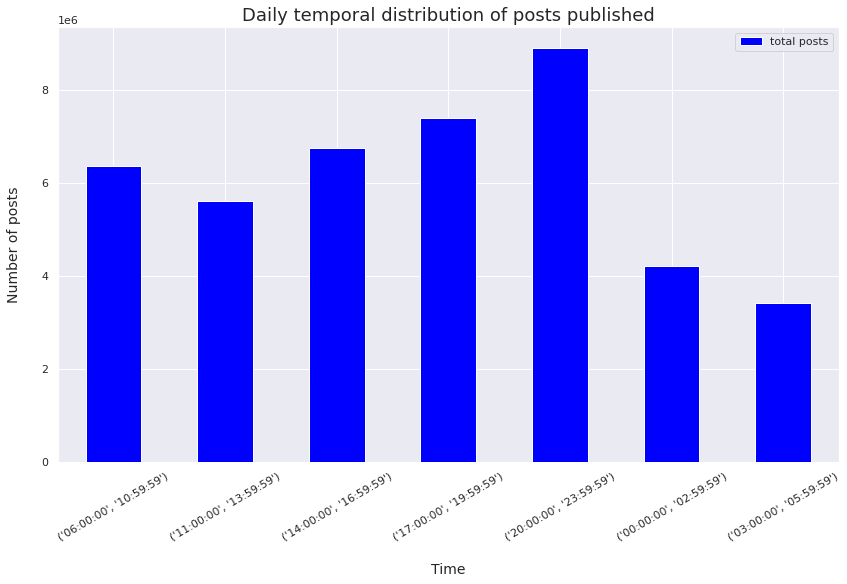

In [ ]:
time_interval(posts, time_intervals)

## RQ4

## RQ5

## RQ6

## RQ7

*What's the probability that a post receives more than 20% "likes" of the number of followers a user has?*

In [ ]:
profiles_followers = profiles[['sid', 'followers']]
profiles_followers = profiles_followers.dropna()

all = 0
tot = 0
for chunk in pd.read_csv('/content/drive/MyDrive/ADM/instagram_posts.csv', sep='\t', chunksize=500000, usecols=['sid_profile', 'numbr_likes']): 
    data = pd.merge(chunk, profiles_followers, left_on='sid_profile', right_on='sid').drop('sid', axis=1)   
    all += (data.apply(lambda x: x.numbr_likes / (x.followers+1), axis=1) > 0.2).sum()  # we add +1 to consider also all the profiles with 0 followers                     
    tot += len(data)                                                                   # because division by 0 is not possible

    # merging the chunks and the profiles to get a new dataset with n_likes and n_followers for every post
    # counting all the rows that have (n_likes / n_followers) > 0.2

print(f"The probability is: {round(all/tot, 3) * 100}%")

The probability is: 15.1%


We get this probability couting all the posts in which the division between number of likes and number of followers was higher than 0.2. Doing this we have also consider all the profiles (usually those that has 0 or few follower) that has more like than followers. We leave those profile because they give us an explanation of how this social works and tell us that not always the number of followers is relevant. However this probability is not so high: a big part of profile followers does not interact so much with that profile.

*Do users usually return to locations? Extract the probability that a user returns to a site after having posted it in the past. Does that probability make sense to you? Explain why or why not.*

In [ ]:
profiles = list(profiles.sid)
prof_dict = {k: [] for k in profiles}       # creating a dictionary with all profiles

for chunk in pd.read_csv('/content/drive/MyDrive/ADM/instagram_posts.csv', sep='\t', chunksize=500000, usecols=['sid_profile', 'location_id']): 
    chunk = chunk[chunk.sid_profile != -1].dropna()             # cleaning the chunk
    for loc, prof in zip(chunk.location_id, chunk.sid_profile):
        prof_dict[int(prof)].append(loc)            # appending to profiles any locations they visited

count = 0
tot = 0
for item in prof_dict.values():         # counting for every profiles how many times they visited every location where they posted
    d = Counter(item)
    v = [i for i in d.values() if i > 1]        
    count += len(v)                     # counting the locations where they have been more than once
    tot += len(set(item))

print(f"The probability is: {round(count/tot, 3) * 100}%")

The probability is: 18.8%


We compute this  probability supposing that a user posts a post only when he goes in a location. So of course this result can not have sense because a user could also posts something with the same location of the previous posts having taken a picture in the same moment of the previous. So posting a post with a location that is the same of some previous one not imply that the user is back in the same place and so this probability doesn't have any sense.

## RQ8

*Does more 'likes' also mean more comments? Plot a scatter plot of 'likes' vs comments for posts.*

In [ ]:
posts = pd.read_csv('/content/drive/MyDrive/ADM/instagram_posts.csv', sep='\t', usecols=['numbr_likes', 'number_comments', 'cts'])

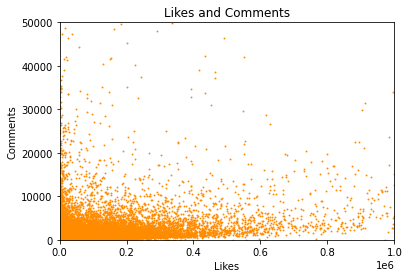

In [ ]:
plt.scatter(posts.numbr_likes, posts.number_comments, color='darkorange', s=.8)
plt.xlim([0, 1000000])      # Here we don't care about outliers but we only want readble informations on the scatterplot so we use appropriate ranges
plt.ylim([0, 50000])
plt.title('Likes and Comments')
plt.xlabel('Likes')
plt.ylabel('Comments')
plt.show()

Plotting the number of likes with number of comments of posts we realize that there is not so much correlation between tis two variable. In fact having more likes do not imply having more comments: if we imagine a regression line in this plot it would have a little inclination.  Therefore more likes doesn't mean also more comments, rather we notice that as the likes increase, the comments remain constant.




*Can you find any significant relationship between the time a user publishes a post and the number of comments and “likes”? Use an appropriate statistical test or technique and support your choice.*

In [ ]:
posts.cts = pd.to_datetime(posts.cts).dt.floor('h').dt.time

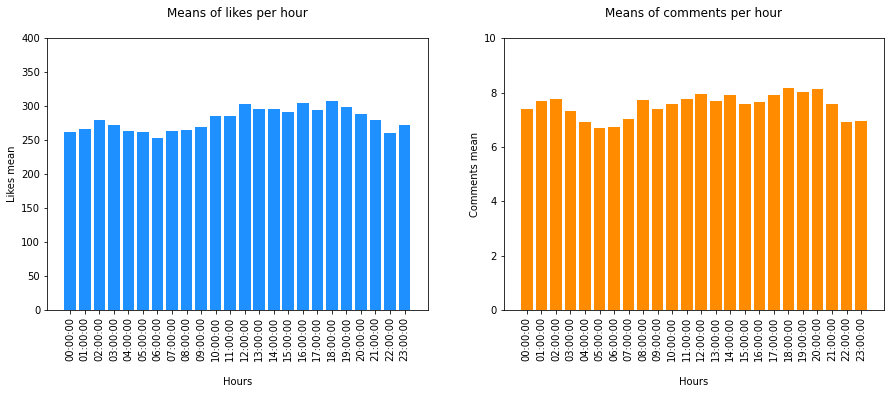

In [ ]:
# Plotting means of likes and comments for every hours

hours = list(map(str,sorted(list(set(posts.cts))[1:])))
mean_likes = posts.numbr_likes.groupby(posts.cts).apply(lambda x: x.mean())
mean_comments = posts.number_comments.groupby(posts.cts).apply(lambda x: x.mean())

fig, ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].bar(hours,list(mean_likes), color="dodgerblue")
ax[0].set(title="Means of likes per hour\n", xlabel="\nHours", ylabel="Likes mean", ylim=[0, 400])
ax[0].tick_params(axis='x', rotation=90)

ax[1].bar(hours,list(mean_comments), color="darkorange")
ax[1].set(title="Means of comments per hour\n", xlabel="\nHours", ylabel="Comments mean", ylim=[0, 10])
ax[1].tick_params(axis='x', rotation=90)

plt.show()

At first sight it would not seem that the avarage values of likes and comments are affected by the hour. 
To verify this we could run the ANOVA test to check with a statistcal test if the null Hypotesis of all equal means would not be rejected but as we will see in the next question the mean is not a good value to summarize the ditribution carachteristics. In fact we know that the average is not a robust position index because, like in our case, there are very high values that unbalance the average towards high values and so it is very different from the center of distribution. For this reason we can use the medians.

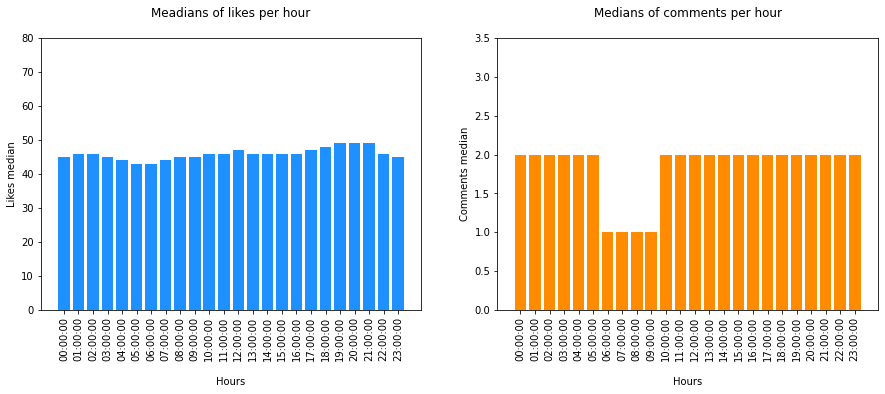

In [ ]:
# Plotting median of likes and comments for every hours

hours = list(map(str,sorted(list(set(posts.cts))[1:])))
med_likes = posts.numbr_likes.groupby(posts.cts).apply(lambda x: x.median())
med_comments = posts.number_comments.groupby(posts.cts).apply(lambda x: x.median())

fig, ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].bar(hours,list(med_likes), color="dodgerblue")
ax[0].set(title="Meadians of likes per hour\n", xlabel="\nHours", ylabel="Likes median", ylim=[0, 80])
ax[0].tick_params(axis='x', rotation=90)

ax[1].bar(hours,list(med_comments), color="darkorange")
ax[1].set(title="Medians of comments per hour\n", xlabel="\nHours", ylabel="Comments median", ylim=[0, 3.5])
ax[1].tick_params(axis='x', rotation=90)

plt.show()

As we can see there the median values for each hours looks to be more closer to each other than the means. Another time it comes from the fact that the time does not discriminate the number of likes and comments.

However, a consideration must be made: since the average number of likes and comments is not so far from day and night (as we can see in barplots above) as should it be and having taken posts from multiple parts of the worlds, maybe means that the time zone was not considered. If this is true, it is not possible to report valid results about this topic.

*What is the distribution of followers? Plot the empirical distribution of followers amongst all users and extract the mean, mode, and quantiles. Interpret those figures.*

The mean is: 4739.9
The mode is: 0.0

    Quantile   Value
0        10    60.0
1        20   124.0
2        30   198.0
3        40   289.0
4        50   406.0
5        60   563.0
6        70   804.0
7        80  1191.0
8        90  2502.0 



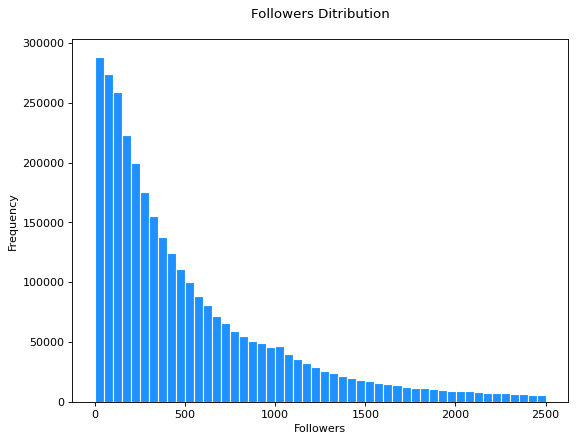

In [ ]:
followers = np.array(profiles.followers.dropna())

mean = round(followers.mean(), 2)
stats = Counter(followers)
mode = max(stats, key=stats.get)            # taking the max value after grouping by number of followers

rng = np.arange(10,91,10)
quant = np.percentile(followers,rng)        # computing the decils of profiles followers
data = {'Quantile': rng, 'Value': quant}
quantiles = pd.DataFrame(data)

print("The mean is:", mean)
print("The mode is:", mode)
print("\n", quantiles, "\n")

follower = followers[followers < quant[-1]]    # removing last 10% of profiles with highest number of follower

plt.figure(figsize=(8, 6), dpi=80)
plt.hist(follower, bins = 50, ec="white", color="dodgerblue")      # plotting just the 90% of lowest units to have a clear rapresentation
plt.title("Followers Ditribution\n")                               #  of the followers distribution
plt.xlabel("Followers")
plt.ylabel("Frequency")
plt.show()

From the chart we can see how, incresing the number of the followers, the quantity of profiles with this number decrease very quickly. This implies that there are a lot of profiles with a low number of followers and only a few profiles with many followers, as we can see also from the quantiles values (90% ofprofiles have less than 2500 followers). This of course has a strong influence on the mean because the really high numers of followers tend to make it shift towards higher values. In fact, we can see how the median has a much lower value: 406 is the median and 4740 is the mean. The mode tell us that there are a lot of profile with no followers or really low value. 

*What are histograms, bar plots, scatterplots and pie charts used for?*

* <ins> Histogram </ins>: It's used to represent the distribution of a single continuous variable. The bins are the intervals in which this variable it's been splitted and the high of the column represents how many time a value of this variable occurred in that interval.
* <ins> Bar Plot </ins>: This chart corresponding to the Histogram for discrete variables. Every bin represents a value which can be assumed by the variable and the high of the column tells us how many times the variable assumes that value.
* <ins> Scatterplot </ins>: This chart is used to plot a series of units that have two different attributes. Thanks to this we can see how the variables behave with each other, if there is some type of correlation.
* <ins> Pie Chart </ins>: The pie chart is another way to represent what values a discrete variable takes  and, reporting these values of the respective relative frequencies, give use a visual the information what portion of the total every different value takes.

*What insights can you extract from a Box Plot?*

The Box Plot is a type of graph used to visually summarize many informations of a continuous variable: 
* the horizontal line insiede the box represent the median of the distribution;
* the edges of the box represents the first and the third quartile (25% and 75% of the units)
* the horizontals line at the end of the vertical ones are a range defined a range $(Q_3 \pm 1.5 * Q_1)$ outside of which we find the outliers.

Watching this plot we can have visually a first information about the variable's distibution.

# Bonus Points

a) Sort the users in terms of number of followers and divide them into two groups: for the first group, take only the top 10% regarding "followers", and for the second one, take the rest. Now compare the mean of time intervals between posts for the two categories. Do you notice something relevant?

In [ ]:
profiles = pd.read_csv('/content/drive/MyDrive/ADM/instagram_profiles.csv', sep='\t', usecols=['sid', 'followers'])
sort_profiles = profiles.sort_values('followers', ascending=False)[profiles['followers'].notna()]  
# we remove all the profiles without followers attribute

tresh = sort_profiles.followers.quantile(.9)                        # finding last decil
first_group = sort_profiles[sort_profiles.followers > tresh]        # splitting the groups
second_group = sort_profiles[sort_profiles.followers <= tresh]

In [ ]:
posts = pd.read_csv('/content/drive/MyDrive/ADM/instagram_posts.csv', sep='\t', usecols=['post_id', 'cts', 'sid_profile'])

posts = posts[posts['sid_profile'] != -1]                                        # removing posts with missing profile 
posts.cts = pd.to_datetime(posts.cts)                                            # converting to datetime cts column
group = posts.cts.groupby(posts.sid_profile).apply(list).reset_index()           # grouping posts.cts by profiles
group['mean_time'] = group.cts.apply(lambda x: ((max(x)-min(x)) / (len(x))))     # finding average publication period for each profile
group = group[group.mean_time != '0 days 00:00:00']                              # removing profiles with less than two posts

In [ ]:
data_first = pd.merge(group, first_group, left_on='sid_profile', right_on='sid').drop('sid', axis=1)  # merging profiles with average posting period
data_second = pd.merge(group, second_group, left_on='sid_profile', right_on='sid').drop('sid', axis=1)

mean_1 = data_first.mean_time.mean()
mean_2 = data_second.mean_time.mean()

print(f'Mean of the first group: {mean_1}')
print(f'Mean of the first group: {mean_2}')
print(f'The difference between the second and first groups is: {mean_2-mean_1}')

Mean of the first group: 19 days 12:13:58.554878473
Mean of the first group: 19 days 18:07:14.784826943
The difference between the second and first groups is: 0 days 05:53:16.229948470


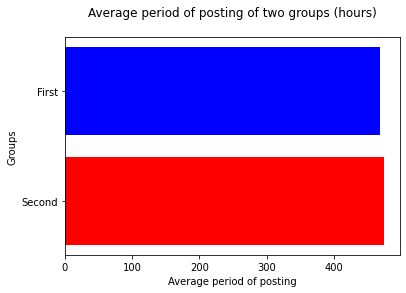

In [ ]:
hours_1 = mean_1.days * 24 +mean_1.seconds //60 //60
hours_2 = mean_2.days * 24 +mean_2.seconds //60 //60
    
plt.barh([0,1], [hours_2, hours_1], color=['r','b'])
plt.title('Average period of posting of two groups (hours)\n')
plt.ylabel('Groups')
plt.xlabel('Average period of posting')
plt.yticks([0,1], ('Second', 'First'))
plt.show()

After having divide all the profiles in two groups and have found the avarage period of posting for everyone, we have compared the two means of that values as we can see on above. The results show us how the means are not so different: in fact the second group get an higher value but with just about 6 hours more. We should have expect that profiles with more followers were more active but this not seems to being right.

b) Assume users publish their posts the same day pictures or videos are taken: Are there users that have visited the same location on the same day? How about the same week? Extract the results and explain them.

In [ ]:
posts = pd.read_csv('/content/drive/MyDrive/ADM/instagram_posts.csv', sep='\t', usecols=['location_id', 'cts', 'sid_profile'])

posts = posts[posts.sid_profile != -1]
cts = pd.to_datetime(posts.cts)

In [ ]:
posts.cts = cts.dt.date
t = posts.groupby([posts.location_id, posts.cts]).count()  # grouping by location, than by hour and then count how many unit are in these groups
tot = sum(t.sid_profile > 1)                               # counting how many have more posts in same location at same hour

print(f'It happened {tot} times that two profiles have visited the same location in the same day')

It happened 1565766 times that two profiles have visited the same location in the same day


In [ ]:
posts.cts = cts
week = list(map(str, posts.cts.dt.isocalendar().week))
year = list(map(str, posts.cts.dt.year))

date = []                       # creating new variable with week and years to group 
for i in range(len(week)):
    date.append(week[i] + ' ' +year[i])
posts.cts = date

t = posts.groupby([posts.location_id, posts.cts]).count()
tot = sum(t.sid_profile > 1)     # counting how many have more posts in same location at same hour

print(f'It happened {tot} times that two profiles have visited the same location in the same week')

It happened 1772018 times that two profiles have visited the same location in the same week


c) Implement a text data analysis (also known as text mining) of the field "description" from instagram_posts.csv for descriptions written in English. Use appropriate visualizations and statistics to highlight the words (and probably the topics) provided for the users in that field.

--------------------------------------------------------------------------------

# Command Line Question

--------------------------------------------------------------------------------

# Algorithmic Question

## AQ1

[AQ1] Given the following pseudocode, answer the questions:



```
Input: 
    N : an integer 
    List : array of characters of length N without repetition
    
function f1(sequence, end): 
    For i=0 To end:
        OUTPUT sequence[i]
    EndFor
    Output "\n"
    
function f2(sequence, start, end): 
    If start = end: 
        f1(sequence, end)
    Else
        For i=start To end: 
            temp <-- sequence[start]
            sequence[start] <-- sequence[i]
            sequence[i] <-- temp
            f2(sequence, start+1, end)
            temp <-- sequence[start]
            sequence[start] <-- sequence[i]
            sequence[i] <-- temp
f2(List, 0, N)
```

What is the output of this algorithm? Describe the mechanism of the algorithm in detail . We do not want to know only its final result. (Describe one example on your own)

In [ ]:
The aligorithm is the Full Permutation of an array

if input list = [1, 2, 3]
then output
123
132
213
231
312
321

function f1 output the array in Order
function f2 swap the order of characters in the array then output it in the new order

What is asymptotically (i.e., we are asking for big-O complexity) the algorithm's running time as a function of N?

O(N^2)

Is this algorithm the optimal one to produce this output? If not, can you suggest a better algorithm to perform the same task?

The algorithms is not the optimal one

better algorithm suggested below

In [ ]:
def f(list_start: list, list_remain: list):
    if len(list_remain) == 1:
        print(list_start+list_remain)
    else:
        for i in range(len(list_remain)):
            list_temp_remain = list_remain.copy()
            f(list_start+[list_temp_remain.pop(i)], list_temp_remain)


l = [1, 2, 3]
f([], l)


[1, 2, 3]
[1, 3, 2]
[2, 1, 3]
[2, 3, 1]
[3, 1, 2]
[3, 2, 1]


In [ ]:
import copy

def allPermutation(n):
    all_permutation = [[1]]
    for i in range(1, n):
        update_permutation = []
        len1 = len(all_permutation)
        for j in range(len1):
            len2 = len(all_permutation[j]) + 1
            for k in range(len2):
                perm = copy.deepcopy(all_permutation[j])
                perm.insert(k, i + 1)
                update_permutation.append(perm)
        all_permutation = update_permutation
    return all_permutation


print(allPermutation(3))

[[3, 2, 1], [2, 3, 1], [2, 1, 3], [3, 1, 2], [1, 3, 2], [1, 2, 3]]


## AQ2

[AQ2] Considering the following problem, answer the questions:

Alex has a ribbon of length N. He wants to cut the ribbon in a way that fulfils the following three conditions:

Each piece of the cut should have an integer length.

He should at least cut the ribbon once.

The multiplication of the length of all the pieces be the maximum possible

1 Implement a recursive algorithm to help Alex find the maximum possible value after multiplying the length of the pieces. Explain your algorithm in detail.

In [ ]:
def cuttingRibbon1(self, n: int) -> int:
  if n == 2:
    return 1
    res = -1
    for i in range(1, n):
      res = max(res, max(i * self.cuttingRope(n - i),i * (n - i)))
  return res

"""
The product is maximized when all segments are of equal length. The optimal number of segments is 3.

Each time we cut a piece of ribbon into two pieces, the remaining pieces can be cut or not, so we get a recursive function.

F(n)=max(i×(n−i),i×F(n−i)),i=1,2,...,n−2。
"""

'\nThe product is maximized when all segments are of equal length. The optimal number of segments is 3.\n\nEach time we cut a piece of ribbon into two pieces, the remaining pieces can be cut or not, so we get a recursive function.\n\nF(n)=max(i×(n−i),i×F(n−i)),i=1,2,...,n−2。\n'

2 Show that the algorithm has exponential running time.

The ribbon are divided into up to n segments, each with a length of 1 and a recursive depth of n. So the running time is exponential.

3 Now provide a polynomial solution, based on dynamic programming, and compute its running-time complexity.

In [ ]:
def cuttingRibbon2(n: int) -> int:
  dp = [0 for _ in range(n + 1)]
  dp[2] = 1
  for i in range(3, n + 1):
    for j in range(i):
      dp[i] = max(dp[i], max((i - j) * j, j * dp[i - j]))
  return dp[n]

running-time complexity: O(n^2)

4.Evaluate the running time of your algorithm for the sizes (Ns) in the range of [2, 25], plot the results, and interpret it (if you have implemented two algorithms, please include both in the plot and compare them).

In [ ]:
for k in range(2, 25):
  start = time.clock()
  cuttingRibbon2(k)
  end = time.clock()
  print (end - start)

0.00011100000000396903
1.3000000024021574e-05
1.2000000026546331e-05
1.5999999959603883e-05
2.0000000006348273e-05
3.299999997352643e-05
3.299999997352643e-05
4.3000000005122274e-05
5.0999999984924216e-05
5.9000000021569576e-05
7.600000003549212e-05
7.700000003296736e-05
8.300000001781882e-05
9.699999998247222e-05
0.00011299999999891952
0.00012299999997367195
0.00012599999996609768
0.00014599999997244595
0.00020900000004075991
0.0002270000000521577
0.0004389999999716565
0.0002579999999738902
0.00026300000001810986


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


5.(Optional, mini bonus) Is the algorithm of question 3 optimal? If you belive it, can you prove it? If not, can you find a faster algorithm? In case you found a faster algorithm implement it and explain your algorithm in detail.

In [ ]:
"""
We find that any number greater than 3 can be split into the sum of the numbers 1, 2, 3, 
and their remainder to 3 is always 0, 1, 2 
so we can just use dp[0], dp[1], dp [2] means all values greater than 3.
In this way, the repeated use of the dp array can be completed with only one traversal, and the time complexity can be reduced to O(N).
"""

def cuttingRibbon3(self, n):
  dp = [0, 1, 1]
  for i in range(3, n + 1):
    dp[i % 3] = max(max(dp[(i - 1) % 3], i - 1),
                    2 * max(dp[(i - 2) % 3], i - 2),
                    3 * max(dp[(i - 3) % 3], i - 3))
return dp[n % 3]